<a href="https://colab.research.google.com/github/Navoditamathur/ImageCrackSegmentation/blob/main/WaveletUnet_Crack_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/crack_segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: crack_segmentation_dataset/masks/noncrack_noncrack_concrete_wall_29_6.jpg.jpg  
  inflating: __MACOSX/crack_segmentation_dataset/masks/._noncrack_noncrack_concrete_wall_29_6.jpg.jpg  
  inflating: crack_segmentation_dataset/masks/Rissbilder_for_Florian_9S6A3123_71_639_3458_2993.jpg  
  inflating: __MACOSX/crack_segmentation_dataset/masks/._Rissbilder_for_Florian_9S6A3123_71_639_3458_2993.jpg  
  inflating: crack_segmentation_dataset/masks/forest_070.jpg  
  inflating: __MACOSX/crack_segmentation_dataset/masks/._forest_070.jpg  
  inflating: crack_segmentation_dataset/masks/Rissbilder_for_Florian_9S6A2815_1237_159_3590_2891.jpg  
  inflating: __MACOSX/crack_segmentation_dataset/masks/._Rissbilder_for_Florian_9S6A2815_1237_159_3590_2891.jpg  
  inflating: crack_segmentation_dataset/masks/Rissbilder_for_Florian_9S6A2791_738_1464_2625_2981.jpg  
  inflating: __MACOSX/crack_segmentation_dataset/masks/._Rissbilder_for_Florian_9S

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, cohen_kappa_score
from scipy.spatial.distance import directed_hausdorff


from glob import glob
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

seed = 42
image_size = 256

<ipython-input-2-082edb2207f3>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')

Currently using "cuda" device.


In [4]:
path_images = r'crack_segmentation_dataset/images/'
path_masks = r'crack_segmentation_dataset/masks/'

## be sure to match jpg/png to data set being used!
images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.jpg')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.sample(2)

,images,masks
967,crack_segmentation_dataset/images/CRACK500_201...,crack_segmentation_dataset/masks/CRACK500_2016...
513,crack_segmentation_dataset/images/CRACK500_201...,crack_segmentation_dataset/masks/CRACK500_2016...


In [5]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # add some color augmentations manually if needed
    T.ToTensor()
])

In [6]:
class CrackDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
        mask_tensor /= 255.

        return image_tensor, mask_tensor

    def collate_fn(self, batch):
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, and test size: {len(test)}')

Train size: 9038, and test size: 2260


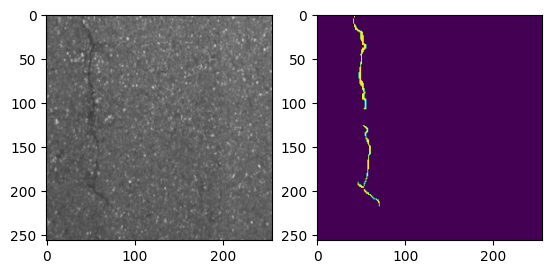

In [8]:
ds = CrackDataset(train)
plt.subplot(121)
plt.imshow(ds[1][0].cpu().detach().numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(ds[1][1].cpu().detach().numpy().transpose(1,2,0))

In [9]:
@torch.no_grad()
def validate_test_image(model, dataset, dataset_type):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()

    image = cv2.imread(row['images'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = train_transforms(image).unsqueeze(0).to(device)

    mask = cv2.imread(row['masks'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (image_size, image_size))
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    model.eval()
    output = model(image_tensor)
    predicted_mask = output['out'][0].cpu().detach().numpy().transpose(1, 2, 0)

    # Flatten the masks for computing F1 score
    ground_truth_flat = mask.flatten()
    predicted_flat = (predicted_mask > 0.5).astype(np.uint8).flatten()

    # Compute F1 score
    f1 = f1_score(ground_truth_flat, predicted_flat, average='weighted')

    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(ground_truth_flat, predicted_flat)

    set1 = np.array(np.where(ground_truth_flat == 1)).T
    set2 = np.array(np.where(predicted_flat == 1)).T
    mhd = directed_hausdorff(set1, set2)
    mhd = mhd[0]

    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(133)
    plt.title('Predicted mask\nF1: {:.4f}, Kappa: {:.4f}, MHD: {:.4f}'.format(f1, kappa, mhd))
    plt.imshow(predicted_mask, cmap='gray')

    plt.suptitle('Comparison of Original and Predicted Masks on '+dataset_type+' dataset:', fontsize=16)  # Add main title

    plt.tight_layout()
    plt.show()
    plt.pause(0.001)


In [10]:
batch_size = 16
image_size = 256
epochs = 20
path = r'seg_model.pth'

In [11]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def get_model(output_channels=1, unfreeze=True):
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=False)

    for param in model.parameters():
        param.requires_grad = unfreeze

    model.classifier = DeepLabHead(2048, output_channels)
    return model.to(device)

model = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=path):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # if unfreeze=True -> 1e-4, 1e-5, so not to ruin good init w
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early = EarlyStopping()

In [14]:
def train_one_batch(batch, model, criterion, optimizer):
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    output = torch.sigmoid(output['out'])  # Corrected line
    loss = criterion(output, masks)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
    images, masks = batch
    output = model(images)
    output = torch.sigmoid(output['out'])  # Corrected line
    loss = criterion(output, masks)
    return loss.item()


In [15]:
def compute_score(model, dataloader):
    model.eval()
    all_ground_truth = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            output = model(images)
            predicted_flat = (torch.sigmoid(output['out']) > 0.5).cpu().numpy().flatten()
            ground_truth_flat = masks.cpu().numpy().flatten()

            all_ground_truth.extend(ground_truth_flat)
            all_predictions.extend(predicted_flat)

    f1 = f1_score(all_ground_truth, all_predictions, average='weighted')
    kappa = cohen_kappa_score(all_ground_truth, all_predictions)

    return f1, kappa

In [16]:
test_dataset = CrackDataset(test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn, drop_last=True)

Fold 1/5
Epoch 1/20


  0%|          | 0/451 [00:00<?, ?it/s]

Train loss: 0.0447.


  0%|          | 0/113 [00:00<?, ?it/s]

Valid loss: 0.0485.
--------------------------------------------------
Model saved to: seg_model.pth


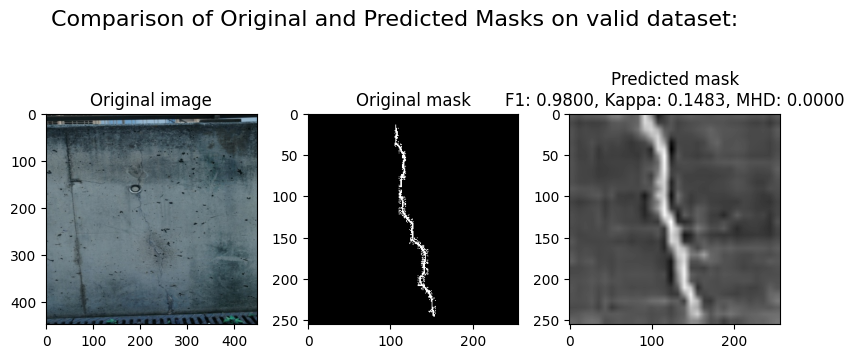

Epoch 2/20


  0%|          | 0/451 [00:00<?, ?it/s]

Train loss: 0.0424.


  0%|          | 0/113 [00:00<?, ?it/s]

Valid loss: 0.0495.
--------------------------------------------------
INFO: Early stopping counter 1 of 5


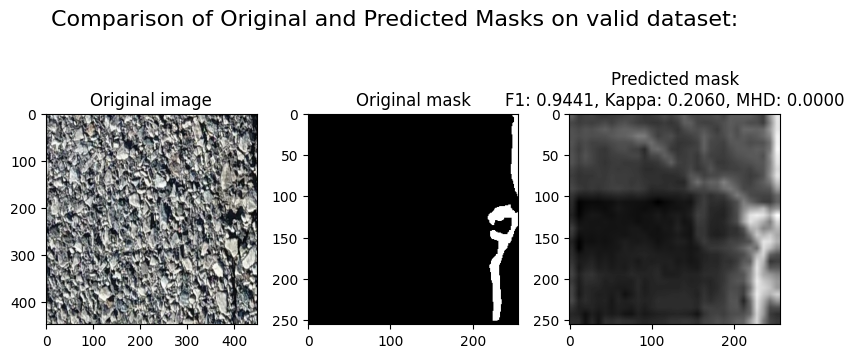

Epoch 3/20


  0%|          | 0/451 [00:00<?, ?it/s]

In [ ]:
# Set the number of folds for cross-validation
num_folds = 5

# Initialize KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Lists to store the average metrics for each fold
f1_scores, kappas = [], []


# Lists to store the average training and validation losses for each fold
average_train_losses = []
average_valid_losses = []

best_model = None
best_valid_loss = float('inf')


for fold, (train_index, valid_index) in enumerate(kf.split(train)):
    print(f'Fold {fold + 1}/{num_folds}')

    # Create train and validation datasets for the current fold
    # Create datasets for the current fold
    train_dataset = CrackDataset(train.iloc[train_index])
    valid_dataset = CrackDataset(train.iloc[valid_index])


    # Create dataloaders for train and validation datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

    # Rest of your training loop remains the same
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        epoch_train_losses, epoch_valid_losses = [], []

        model.train()
        for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
            batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
            epoch_train_losses.append(batch_train_loss)
        epoch_train_loss = np.array(epoch_train_losses).mean()
        train_losses.append(epoch_train_loss)

        print(f'Train loss: {epoch_train_loss:.4f}.')

        model.eval()
        for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
            batch_valid_loss = validate_one_batch(batch, model, criterion)
            epoch_valid_losses.append(batch_valid_loss)

        epoch_valid_loss = np.array(epoch_valid_losses).mean()
        valid_losses.append(epoch_valid_loss)
        print(f'Valid loss: {epoch_valid_loss:.4f}.')
        print('-'*50)

        scheduler.step(epoch_valid_loss)
        early(epoch_valid_loss, model=model)

        validate_test_image(model, train.iloc[valid_index], 'valid')

        if early.early_stop:
            print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
            model.load_state_dict(torch.load(path))
            break

    average_train_loss = np.mean(train_losses)
    average_train_losses.append(average_train_loss)

    average_valid_loss = np.mean(valid_losses)
    average_valid_losses.append(average_valid_loss)

    # Save average scores
    f1, kappa = compute_score(model, valid_dataloader)

    f1_scores.append(f1)
    kappas.append(kappa)

    if average_valid_loss < best_valid_loss:
        best_valid_loss = average_valid_loss
        best_model = model.state_dict()

    validate_test_image(model.load_state_dict(best_model), test, 'test')

    test_f1, test_kappa = compute_score(model, test_dataloader)
    print(f'F1 score on test data: {test_f1}')
    print(f'Cohens Kappa on test data: {test_kappa}')


# After all folds are completed, print or use the average losses
print(f'Average Training Loss: {np.mean(average_train_losses)}')
print(f'Average Validation Loss: {np.mean(average_valid_losses)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')
print(f'Average Cohen\'s Kappa: {np.mean(kappas)}')


In [ ]:
model.load_state_dict(best_model)

In [ ]:
test_losses = []
model.eval()
for batch in test_dataloader:
    batch_test_loss = validate_one_batch(batch, model, criterion)
    test_losses.append(batch_test_loss)
test_loss = np.array(test_losses).mean()
print(f'Final Model Test Loss: {test_loss}')

In [ ]:
from sklearn.metrics import f1_score, cohen_kappa_score

test_f1, test_kappa = compute_score(model, test_dataloader)

print(f'Test F1 Score: {test_f1}')
print(f'Test Cohen\'s Kappa: {test_kappa}')